In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 读取instacart中的四个文件
# 读取订单数据
orders = pd.read_csv('./instacart/orders.csv', nrows=100000)

# 读取订单产品数据
order_products = pd.read_csv('./instacart/order_products__prior.csv', nrows=100000)

# 读取产品数据
products = pd.read_csv('./instacart/products.csv', nrows=100000)

# 读取部门数据
departments = pd.read_csv('./instacart/aisles.csv', nrows=100000)

# 数据合并
# 将订单产品数据与产品数据合并
order_products_merged = pd.merge(order_products, products, on='product_id')

# 将合并后的数据与部门数据合并
order_products_dept = pd.merge(order_products_merged, departments, on='aisle_id')

# 将订单数据与上面合并后的数据再次合并
orders_products_complete = pd.merge(orders, order_products_dept, on='order_id')

# 查看合并后的数据
print("合并后的数据形状:", orders_products_complete.shape)
orders_products_complete.head()


合并后的数据形状: (2946, 14)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,8382,23,prior,2,0,10,9.0,3873,1,0,Mountain Spring Water,115,7,water seltzer sparkling water
1,8382,23,prior,2,0,10,9.0,28199,2,0,"Clementines, Bag",123,4,packaged vegetables fruits
2,8382,23,prior,2,0,10,9.0,42372,3,0,Pineapple on the Bottom Greek Yogurt,120,16,yogurt
3,8382,23,prior,2,0,10,9.0,23106,4,0,Pomegranate on the Bottom Non-Fat Greek Yogurt,120,16,yogurt
4,8382,23,prior,2,0,10,9.0,33819,5,0,Original French Vanilla Yogurt,120,16,yogurt


In [10]:
# 创建用户和货架类别的交叉表
# 统计每个用户购买的每个货架类别的商品数量
user_aisle_counts = orders_products_complete.groupby(['user_id', 'aisle']).size().unstack(fill_value=0)

# 查看交叉表的形状
print("用户-货架交叉表形状:", user_aisle_counts.shape)

# 查看交叉表的前几行
print("\n用户-货架交叉表示例:")
print(user_aisle_counts.head())

# 查看每个货架类别的总购买量
print("\n各货架类别总购买量:")
print(user_aisle_counts.sum().sort_values(ascending=False).head(10))


用户-货架交叉表形状: (280, 124)

用户-货架交叉表示例:
aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
23                            0            0                 0   
27                            0            0                 0   
66                            0            0                 0   
90                            0            0                 0   
150                           0            0                 0   

aisle    baby food formula  bakery desserts  baking ingredients  \
user_id                                                           
23                       0                0                   0   
27                       0                0                   0   
66                       0                0                   1   
90                       0                0                   0   
150                      0                0                   0   

aisle    baking supplies decor 

In [19]:
# 使用PCA对用户-货架交叉表进行降维
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 首先对数据进行标准化处理
print("对用户-货架交叉表进行标准化处理...")
scaler = StandardScaler()
user_aisle_scaled = scaler.fit_transform(user_aisle_counts)

# 创建PCA模型并拟合数据
print("应用PCA降维...")
pca = PCA(n_components=10)  # 先降至10个维度
user_aisle_pca = pca.fit_transform(user_aisle_scaled)

# 查看降维后的数据形状
print("PCA降维后的数据形状:", user_aisle_pca.shape)



对用户-货架交叉表进行标准化处理...
应用PCA降维...
PCA降维后的数据形状: (280, 10)


使用K-means聚类算法，分为3类...
聚类的轮廓系数: 0.5058
聚类结果分布:
聚类 0: 30 个用户 (10.71%)
聚类 1: 249 个用户 (88.93%)
聚类 2: 1 个用户 (0.36%)


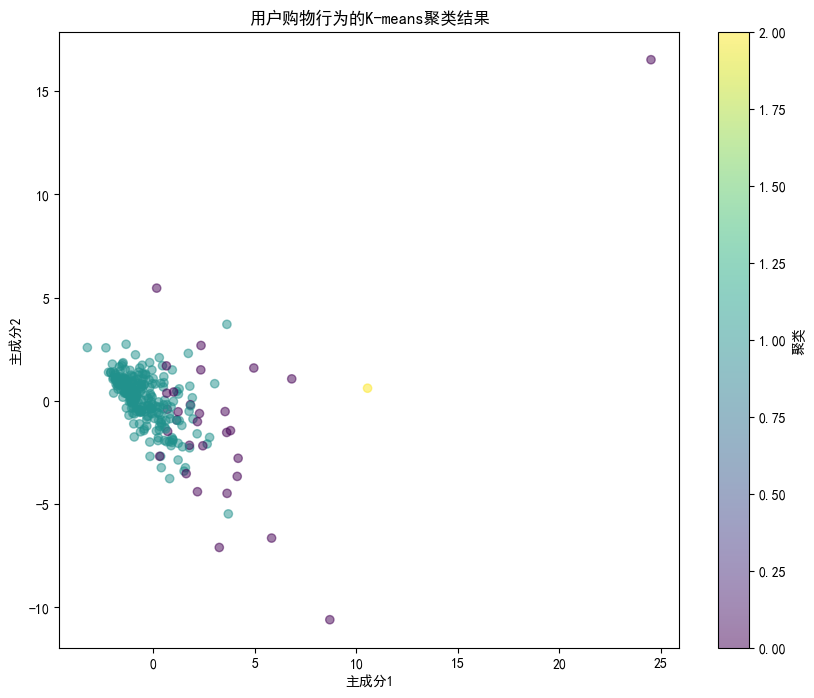

In [20]:
# 使用K-means聚类算法对降维后的数据进行聚类
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib as mpl

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

print("使用K-means聚类算法，分为3类...")
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(user_aisle_pca)

# 计算轮廓系数
silhouette_avg = silhouette_score(user_aisle_pca, clusters)
print(f"聚类的轮廓系数: {silhouette_avg:.4f}")

# 查看聚类结果
print("聚类结果分布:")
unique, counts = np.unique(clusters, return_counts=True)
for i, (cluster, count) in enumerate(zip(unique, counts)):
    print(f"聚类 {cluster}: {count} 个用户 ({count/len(clusters)*100:.2f}%)")

# 可视化聚类结果（使用前两个主成分）
plt.figure(figsize=(10, 8))
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.colorbar(label='聚类')
plt.title('用户购物行为的K-means聚类结果')
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.show()
